# Poker Hand Data Set 

### Relevant Information:

Each record is an example of a hand consisting of five playing
cards drawn from a standard deck of 52. Each card is described
using two attributes (suit and rank), for a total of 10 predictive
attributes. There is one Class attribute that describes the
�Poker Hand�. The order of cards is important, which is why there
are 480 possible Royal Flush hands as compared to 4 (one for each
suit � explained in more detail below).

### Statistics:


|                  |            |               |                  |
| -                | -          | -             | -                |
| Poker Hand       | # of hands	| Probability	| # of combinations|
| Royal Flush      | 4		    | 0.00000154	| 480              |
| Straight Flush   | 36		    | 0.00001385	| 4320             |
| Four of a kind   | 624		| 0.0002401	    | 74880            |
| Full house       | 3744		| 0.00144058	| 449280           |
| Flush            | 5108		| 0.0019654	    | 612960           |
| Straight         | 10200		| 0.00392464	| 1224000          |
| Three of a kind  | 54912		| 0.02112845	| 6589440          |
| Two pairs        | 123552		| 0.04753902	| 14826240         |
| One pair         | 1098240	| 0.42256903	| 31788800         |
| Nothing          | 1302540	| 0.50117739	| 156304800        |
|                  |            |               |                  |
| Total            | 2598960	| 1.0		    | 311875200        |

# Data Analysis

In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
np.random.seed(42)

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dense, LeakyReLU, Embedding, LSTM
from keras.models import Model
from keras.utils import plot_model
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import importlib
import matplotlib as mpl
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

for i in [0,9,13]:
    si = plt.style.available[i]
    plt.style.use(si)

In [8]:
path = '../data/Poker/poker-hand-training-true.data'
df = pd.read_csv(path, names=['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4', 's5', 'c5', 'label'])

In [9]:
df.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,label
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


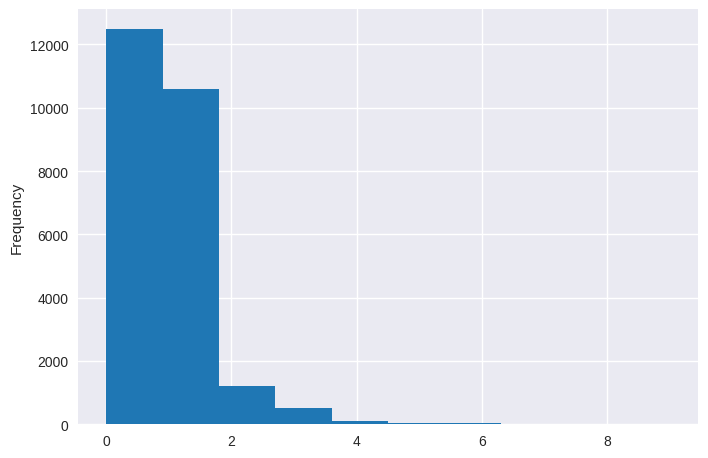

In [48]:
df.label.plot.hist()

In [11]:
# def labelnames(i):
#     names = [
#         'nothing',
#         'one pair',
#         'two pairs',
#         'Three of a kind',
#         'Straight',
#         'Flush',
#         'Full house',
#         'Four of a kind',
#         'Straight Flush',
#         'Royal Flush',
#     ]
#     return names[i]

# df.label = df.label.apply(labelnames)

# Preprocessing Data with Feature Engineering

In [12]:
def categorazer(df):
    data = to_categorical(df)
    cat = []
    for si in data:
        sj = np.array([list(si[2*j][:4])+list(si[2*j+1])  for j in range(5)])
        
        # sum of 5 cards fateures
        features = sj[0]
        for sk in sj[1:]:
            features += sk
        # features normalize]
        features /= 5
        
        cat.append(features)
    return np.array(cat)

In [13]:
x_train = categorazer(df[df.columns[:-1]])
y_train = to_categorical(df[df.columns[-1]])
x_train[0], y_train[0]

(array([0. , 1. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.2, 0.2, 0.2, 0.2], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [17]:
# encode test data
df_test = pd.read_csv('../data/Poker/poker-hand-testing.data')
x_test = categorazer(df_test[df_test.columns[:-1]])
y_test = to_categorical(df_test[df_test.columns[-1]])
x_test[0], y_test[0]

(array([0. , 0. , 0.2, 0.6, 0. , 0. , 0.2, 0. , 0. , 0.4, 0. , 0. , 0. ,
        0. , 0. , 0.2, 0.2, 0. ], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [57]:
# x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
# x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
x_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(x_train, y_train)

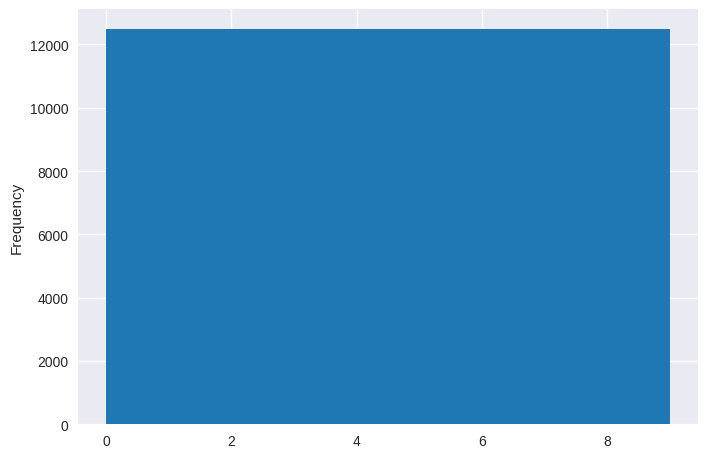

In [55]:
pd.Series(np.argmax(y_resampled, 1)).plot.hist()

# MLP Model

In [19]:
n_cards = x_train.shape[1:]
n_cards

(18,)

In [20]:
tf.reset_default_graph()
inputs = Input(shape=n_cards)
# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64)(inputs)
x = LeakyReLU()(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()
# plot_model(model, to_file='model.png')
# plt.figure(figsize=(10,10))
# img=mpimg.imread('model.png')
# imgplot = plt.imshow(img)
# plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
__________

In [23]:
history = model.fit(x_resampled, y_resampled,
                    validation_data=(x_test,y_test),
                    epochs=4, 
                    batch_size=32,)  # starts training

Instructions for updating:
Use tf.cast instead.
Train on 124930 samples, validate on 999999 samples
Epoch 1/4
124930/124930 [==============================] - 18s 142us/step - loss: 0.4051 - acc: 0.8628 - val_loss: 0.0757 - val_acc: 0.9837
Epoch 2/4
124930/124930 [==============================] - 17s 138us/step - loss: 0.0285 - acc: 0.9936 - val_loss: 0.0290 - val_acc: 0.9933
Epoch 3/4
124930/124930 [==============================] - 17s 139us/step - loss: 0.0148 - acc: 0.9958 - val_loss: 0.0263 - val_acc: 0.9935
Epoch 4/4
124930/124930 [==============================] - 17s 138us/step - loss: 0.0148 - acc: 0.9958 - val_loss: 0.0321 - val_acc: 0.9908


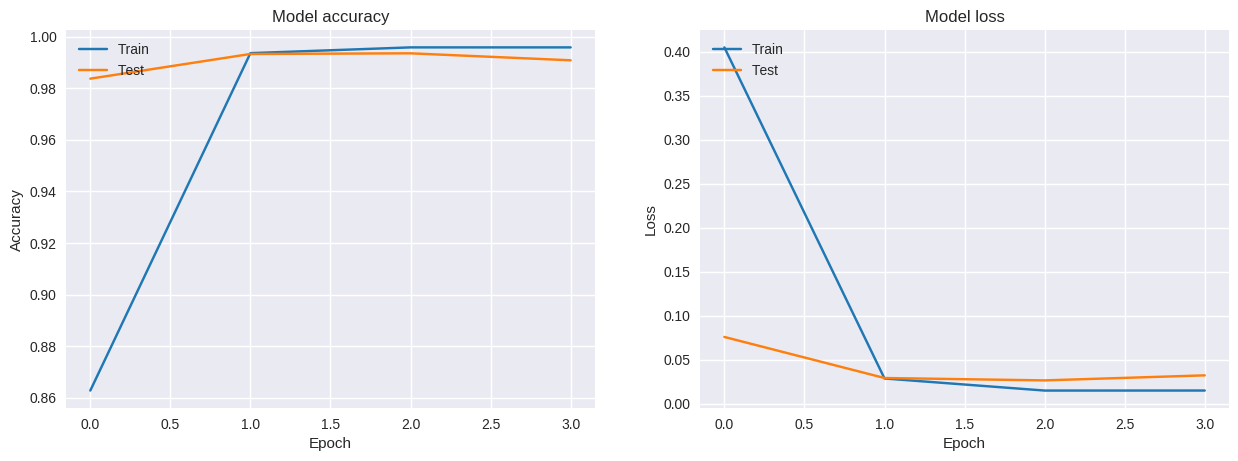

In [49]:
plt.figure(figsize=(15,5))


# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## Validation

In [25]:
from sklearn.metrics import confusion_matrix

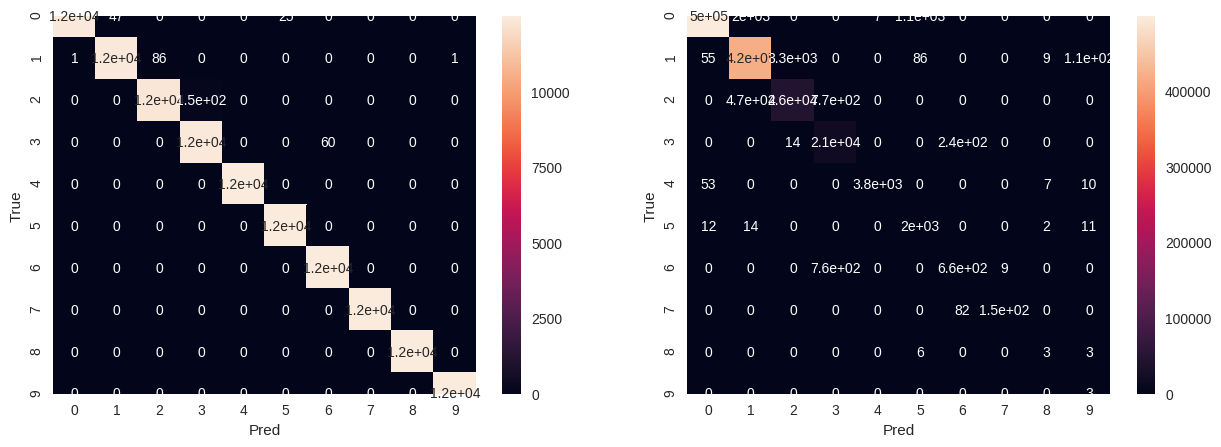

In [50]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
y_pred = model.predict(x_resampled)
y_pred, y_test
matrix = pd.DataFrame(confusion_matrix(y_resampled.argmax(axis=1), y_pred.argmax(axis=1)))
matrix
sns.heatmap(matrix,  annot=True)
plt.ylabel('True')
plt.xlabel('Pred');

plt.subplot(1,2,2)
y_pred = model.predict(x_test)
y_pred, y_test
matrix = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
matrix
sns.heatmap(matrix,  annot=True)
plt.ylabel('True')
plt.xlabel('Pred');

## Use  Random Forest as Base line

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(x_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

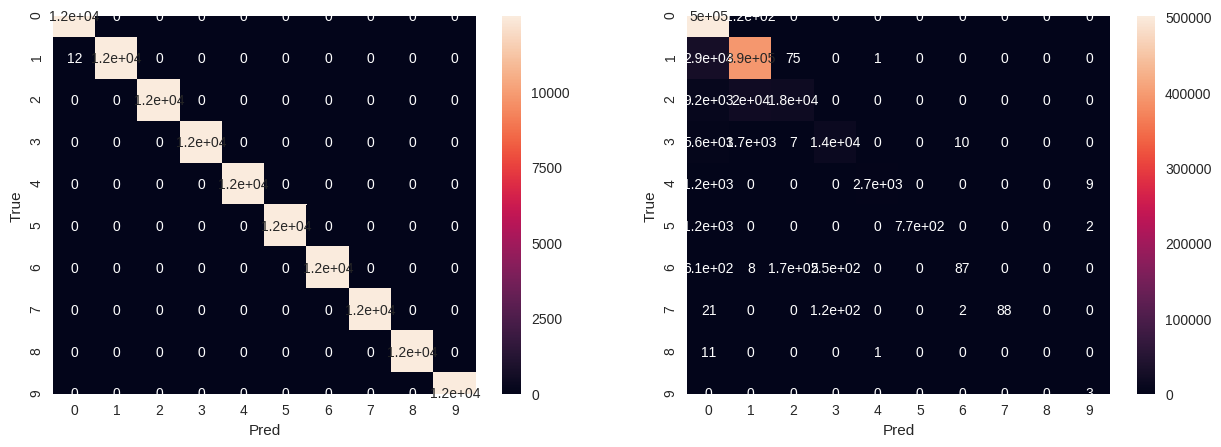

In [59]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
y_pred = clf.predict(x_resampled)
matrix = pd.DataFrame(confusion_matrix(y_resampled.argmax(axis=1), y_pred.argmax(axis=1)))
matrix
sns.heatmap(matrix,  annot=True)
plt.ylabel('True')
plt.xlabel('Pred');

plt.subplot(1,2,2)
y_pred = clf.predict(x_test)
matrix = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
matrix
sns.heatmap(matrix,  annot=True)
plt.ylabel('True')
plt.xlabel('Pred');

## MLP vs RandomForest

In [65]:
y_pred = model.predict(x_test)
print('MLP')
print(classification_report(y_test.argmax(1), y_pred.argmax(1)))

y_pred = clf.predict(x_test)
print('Random Forest')
print(classification_report(y_test.argmax(1), y_pred.argmax(1)))

MLP
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    501208
           1       0.99      0.99      0.99    422498
           2       0.93      0.97      0.95     47622
           3       0.93      0.99      0.96     21121
           4       1.00      0.98      0.99      3885
           5       0.62      0.98      0.76      1996
           6       0.67      0.46      0.55      1424
           7       0.94      0.64      0.76       230
           8       0.14      0.25      0.18        12
           9       0.02      1.00      0.04         3

    accuracy                           0.99    999999
   macro avg       0.73      0.83      0.72    999999
weighted avg       0.99      0.99      0.99    999999

Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    501208
           1       0.95      0.93      0.94    422498
           2       0.99      0.38      0.55     47622
      

#### MLP is the winner